In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Get Data

In [3]:
from nextwind.preproc import make_datasets

In [4]:
datasets = make_datasets(forecast_data='MERRA2') # Tuple containing train, val & test sets

### Fetching 25xWTG data ###
### Fetching weather forecast data from MERRA2 ###
### Preparing train, val & test datasets ###


In [5]:
pd.DataFrame(datasets['train'][0])

,Power,Rotor Speed,Wind Speed,Blade Pitch,Nacelle_X,Nacelle_Y,Wind_X,Wind_Y,Forecast_wind_speed,Forecast_X,Forecast_Y
2019-05-05 00:00:00,1731.108333,0.939035,0.552721,0.005690,-0.529919,0.848048,0.472108,0.881540,6.5,-0.406737,0.913545
2019-05-05 01:00:00,1560.105000,0.911993,0.528627,0.005817,-0.529919,0.848048,0.474748,0.880122,6.2,-0.453990,0.891007
2019-05-05 02:00:00,1892.961667,0.953126,0.568535,0.014250,-0.529919,0.848048,-0.508783,0.860895,5.7,-0.453990,0.891007
2019-05-05 03:00:00,1921.246667,0.957680,0.572961,0.011046,-0.529919,0.848048,0.491008,0.871155,5.4,-0.469472,0.882948
2019-05-05 04:00:00,1912.378333,0.958763,0.561913,0.011816,-0.529919,0.848048,-0.490750,0.871301,5.2,-0.469472,0.882948
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-09 16:00:00,1304.811667,0.866975,0.493965,0.006366,0.990075,0.140538,-0.992438,-0.122744,3.8,0.848048,0.529919
2021-01-09 17:00:00,679.336667,0.707773,0.390826,0.005838,0.955060,0.296413,-0.233560,-0.972342,4.0,0.809017,0.587785
2021-01-09 18:00:00,215.255000,0.610435,0.270462,0.027735,0.749775,0.661693,0.161679,-0.986843,4.1,0.754710,0.656059
2021-01-09 19:00:00,100.945000,0.601815,0.224977,0.036864,0.531183,0.847257,-0.536257,-0.844055,4.2,0.669131,0.743145


# Create sequence window

In [3]:
from nextwind.preproc import SequenceGenerator

In [4]:
n_steps_in = 48
n_steps_out = 12

In [6]:
window = SequenceGenerator(n_steps_in, n_steps_out, n_steps_out,
                           #datasets, load=False,
                           forecast_columns=['Forecast_wind_speed', 'Forecast_X', 'Forecast_Y'],
                           label_columns=['Power'])

### Window details ### 
 Total window size: 60
Input column name(s): ['Power', 'Rotor Speed', 'Wind Speed', 'Blade Pitch', 'Nacelle_X', 'Nacelle_Y', 'Wind_X', 'Wind_Y', 'Forecast_wind_speed', 'Forecast_X', 'Forecast_Y']
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Forecast column name(s): ['Forecast_wind_speed', 'Forecast_X', 'Forecast_Y']
Forecast indices: [48 49 50 51 52 53 54 55 56 57 58 59]
Label column name(s): ['Power']
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59] 

### Train Regr_48in_12out sequences loaded ###
### Val Regr_48in_12out sequences loaded ###
### Test Regr_48in_12out sequences loaded ###


# Retrieve sequences

In [7]:
# To retrieve the values again, or update window sequences with a new dataset
train, val, test = window.get_sequences()

### Train Regr_48in_12out sequences loaded ###
### Val Regr_48in_12out sequences loaded ###
### Test Regr_48in_12out sequences loaded ###


In [8]:
# Retrieve train set sequences
X_train, X_fc_train, y_train = window.train.values()
X_train.shape, y_train.shape

((6150, 48, 11), (6150, 12, 3))

In [9]:
# This also works to retrieve specific datasets
X_train = window.train['X']

# Model Selection

In [10]:
from nextwind.trainer import compile_and_fit, plot_examples, plot_loss

In [11]:
val_performance = {}
test_performance = {}

## Baseline Model

In [12]:
from nextwind.models import Baseline_model

In [15]:
baseline = Baseline_model(window)

In [16]:
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(x=window.val['X'], y=window.val['y'], verbose=1)
test_performance['Baseline'] = baseline.evaluate(x=window.test['X'], y=window.test['y'], verbose=1)

28/28 [==============================] - 0s 1ms/step - loss: 325931.2188 - mean_absolute_error: 446.4207


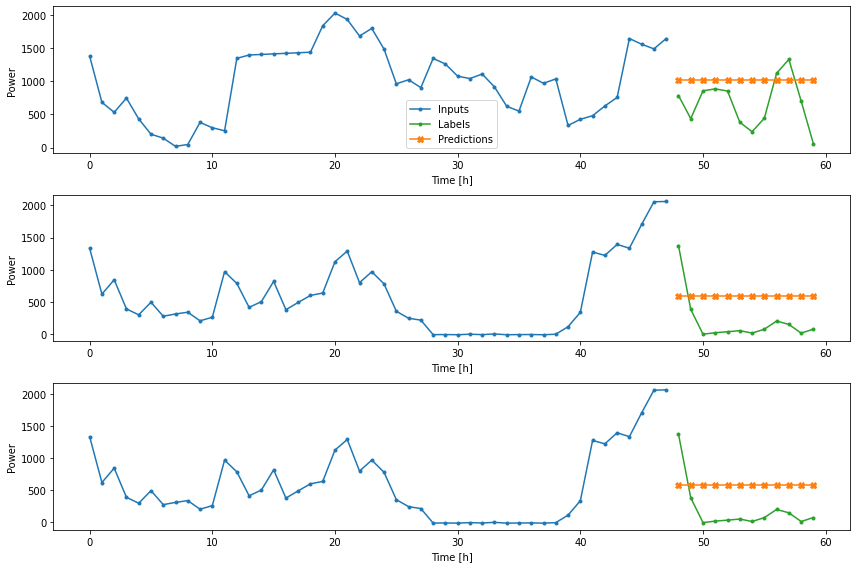

In [21]:
plot_examples(baseline, window, forecast=False)

## Dense_layer Model

In [18]:
num_features = window.val['X'].shape[1]

In [19]:
linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(n_steps_out*num_features),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([n_steps_out, num_features])
])

In [21]:
history = compile_and_fit('test1', linear_model, window, forecast=False)

Epoch 1/20
193/193 [==============================] - 1s 3ms/step - loss: 699190.6875 - mean_absolute_error: 619.0308 - val_loss: 685918.5000 - val_mean_absolute_error: 617.7237
Epoch 2/20
193/193 [==============================] - 0s 2ms/step - loss: 569493.1250 - mean_absolute_error: 553.3326 - val_loss: 559315.8750 - val_mean_absolute_error: 552.8970
Epoch 3/20
193/193 [==============================] - 0s 2ms/step - loss: 498121.0000 - mean_absolute_error: 515.2621 - val_loss: 494571.0938 - val_mean_absolute_error: 518.0837
Epoch 4/20
193/193 [==============================] - 0s 2ms/step - loss: 462810.4688 - mean_absolute_error: 494.7917 - val_loss: 463877.5000 - val_mean_absolute_error: 500.9299
Epoch 5/20
193/193 [==============================] - 0s 2ms/step - loss: 447266.7188 - mean_absolute_error: 484.7794 - val_loss: 451283.4062 - val_mean_absolute_error: 493.5566
Epoch 6/20
193/193 [==============================] - 0s 1ms/step - loss: 441335.3125 - mean_absolute_error: 4

In [30]:
plot_examples(linear_model, window, forecast=False)

ValueError: Your Layer or Model is in an invalid state. This can happen for the following cases:
 1. You might be interleaving estimator/non-estimator models or interleaving models/layers made in tf.compat.v1.Graph.as_default() with models/layers created outside of it. Converting a model to an estimator (via model_to_estimator) invalidates all models/layers made before the conversion (even if they were not the model converted to an estimator). Similarly, making a layer or a model inside a a tf.compat.v1.Graph invalidates all layers/models you previously made outside of the graph.
2. You might be using a custom keras layer implementation with  custom __init__ which didn't call super().__init__.  Please check the implementation of <class 'keras.engine.sequential.Sequential'> and its bases.

## LSTM Model

In [65]:
import pydot
import graphviz

In [66]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [73]:
from nextwind.models import lstm_model

In [74]:
lstm_model = lstm_model(window)

In [75]:
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 48, 11)]     0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 12, 3)]      0           []                               
                                                                                                  
 lstm_27 (LSTM)                 (None, 48, 64)       19456       ['input_7[0][0]']                
                                                                                                  
 lstm_30 (LSTM)                 (None, 12, 64)       17408       ['input_8[0][0]']                
                                                                                              

In [76]:
history = compile_and_fit('lstm_model_1', lstm_model, window)

Train on 6150 samples, validate on 1750 samples
Epoch 1/20
6150/6150 [==============================] - ETA: 0s - loss: 730374.9490 - mean_absolute_error: 656.4500

/home/shmiggit/.pyenv/versions/3.8.12/envs/wind/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6150/6150 [==============================] - 44s 7ms/sample - loss: 730374.9490 - mean_absolute_error: 656.4500 - val_loss: 741887.1218 - val_mean_absolute_error: 691.7928
Epoch 2/20
6150/6150 [==============================] - 42s 7ms/sample - loss: 611028.7303 - mean_absolute_error: 608.9988 - val_loss: 717592.7618 - val_mean_absolute_error: 681.3163
Epoch 3/20
6150/6150 [==============================] - 43s 7ms/sample - loss: 581794.8161 - mean_absolute_error: 588.7161 - val_loss: 699672.1416 - val_mean_absolute_error: 667.8290
Epoch 4/20
6150/6150 [==============================] - 42s 7ms/sample - loss: 524564.2339 - mean_absolute_error: 558.7588 - val_loss: 557238.3930 - val_mean_absolute_error: 605.4355
Epoch 5/20
6150/6150 [==============================] - 39s 6ms/sample - loss: 439737.4460 - mean_absolute_error: 517.3790 - val_loss: 572883.1239 - val_mean_absolute_error: 611.3140
Epoch 6/20
6150/6150 [==============================] - 40s 7ms/sample - loss: 432580.5764 - mea

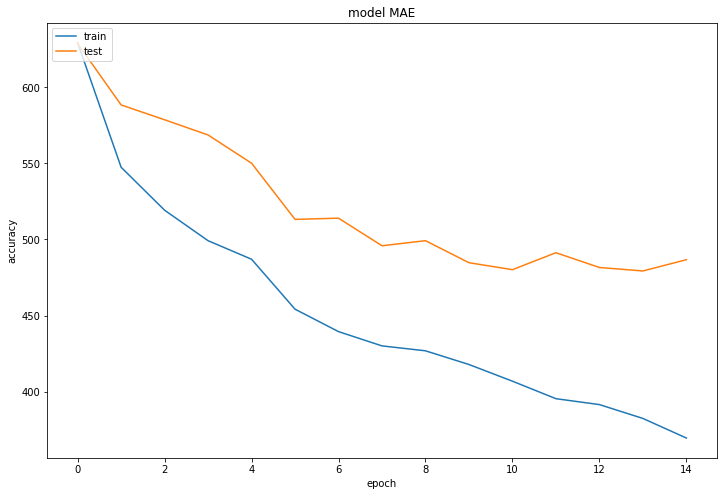

In [31]:
plot_loss(history)

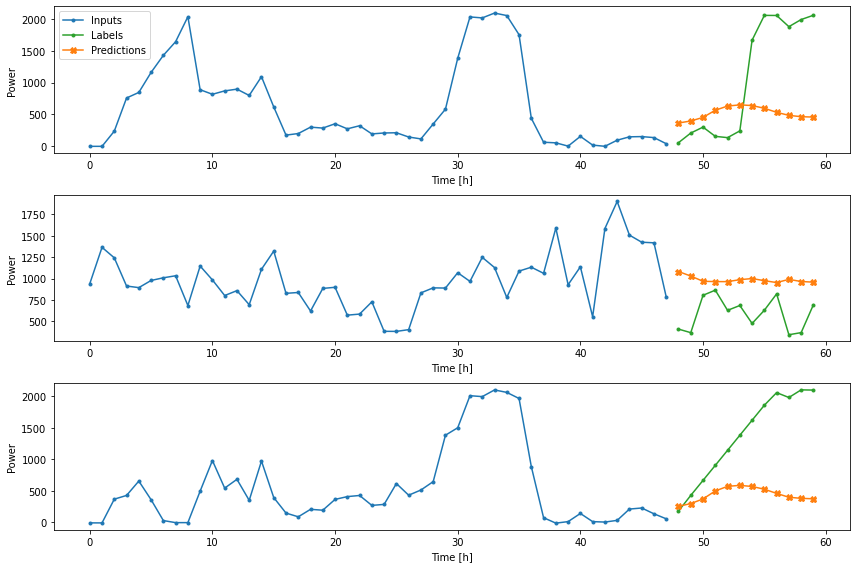

In [34]:
plot_examples(model, window)